# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span> 

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
%pip install .

c:\Users\User\msc_project\sus-optimization\susceptibility-to-fieldmap-fft


c:\Users\User\miniconda3\envs\chi_opt\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


HEAD detached at d9f785b
nothing to commit, working tree clean
Processing c:\users\user\msc_project\sus-optimization\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23545 sha256=0d2d2fe7a9749d35c4d4b98954ea53b23baf316055d8c648d419c98550a4815e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\17\ea\51\22427b7b5d1aced006c3db69245d8a8f88effcb4349a030d61
Successfully built susceptibility-to-fieldmap-fft
  Attempting uninstall: susceptibility-to-fieldmap-fft
    Found existing installation: susceptibility-to-fieldmap-fft 0.0.0
    Uninstalling susceptibility-to-fieldmap-fft-0.0.0:
      Successfully uninstalled susceptibility-to-fieldmap-fft-0.0.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
home_path = "C:/Users/User/msc_project/sus-optimization"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\User\msc_project\sus-optimization


c:\Users\User\miniconda3\envs\saiteki2\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


README.md
__pycache__
chi_calculator.ipynb
chi_opt_pro.ipynb
chi_opt_pro_dB33.ipynb
data
evas_code.ipynb
fixed_chi_test.ipynb
internal_air_only.nii.gz
output
requirements.txt
simulation
soothsayer.ipynb
spinal_cord_voxels_only.nii.gz
sus_optimization.ipynb
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [4]:
path_to_chi_to_fm_fft = "C:/Users/User/msc_project/susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

## <span style="color:lime"> *Util functions used during the optimization process* </span> 

In [4]:
# We need to reate the custom command that creates the fieldmap
def chi_to_fm_ppm(input_file, output_file):

    #Using a custom command for dB0 simulation

    command = [
    "compute_fieldmap",
    "-i", input_file,
    "-o", output_file,
    "-b", "50",
    "-m", "b0SimISMRM"
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True)

    # We need to return the data from the fieldmap created

    
    # Check for errors
    if result.returncode != 0:
        print("Error occurred:", result.stderr)

    else:
        print("Fieldmap simulated correctly", result.stdout)
        sim_fm_img = nib.load(output_file)
        sim_fm_data = sim_fm_img.get_fdata()
        return sim_fm_data

In [7]:
# Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

In [7]:
#from utils.tools import chi_to_fm_ppm
# I believe this is unneeded, might delete laterxx

 # <span style="color:gold"> *Optimization begins!* </span> 

In [18]:
# First lets define the paths for simulation files
# Change run # to avoid mix of outputs per different optimization approach
path_to_iter_dmod_fms =  "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1"
path_to_iter_metrics =  "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1"
counter = 0

########
# This don't change
path_to_sim_metric_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/B1_chi_maps/dB0_033_mod0.nii.gz" # -4.36 (past value)
path_to_segs = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/final_merged_wb_segs.nii.gz"

In [19]:
path_to_avg_resp = "E:/msc_data/ismrm_2025/dB0_033_dup1/fm/C_dmod_meas/simple_avg_respiration.csv"
avg_resp_b0meas_metrics_csv = pd.read_csv(path_to_avg_resp)
avg_resp_b0meas_values = avg_resp_b0meas_metrics_csv["WA()"]
avg_resp_b0meas_values

0    -112.833272
1    -110.888410
2     -53.312953
3      14.442740
4      93.797890
5     127.060660
6      79.966874
7      47.420091
8      45.571511
9      49.048168
10     48.554811
11     35.809311
Name: WA(), dtype: float64

In [22]:
# Hypothesis of just using the some points 
new_series = avg_resp_b0meas_values.iloc[[0, 3, 6]]
new_series.values
# C3 - C7 - T3

array([-120.36618395,   43.31419112,  -12.57306432])

In [38]:
# For convergence plot testing
history = [] 

In [10]:
def f_iair_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Chi air : x[0] = {x[0]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    #ind_body = np.where((ROI_data == 2))
    #ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    # Now we get only 1 value 
    chi_trachea = 0.1*(-9) + 0.9*(x[0])
    chi_lungs = 0.2*(-9) + 0.8*(x[0])

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi_air = x[0]
    #chi3 = x[2]
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    chi_3_name = str(str(float(f"{chi_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving dmod FM... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run14 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1_name} & l: {chi2_name} & air: {chi_3_name}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()


    return difference

In [40]:
def f_iair_vol_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Chi air : x[0] = {x[0]}")
    print(f"Vol_air Tr:  {x[1]}")
    print(f"Vol_air_lungs: {x[2]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    #ind_body = np.where((ROI_data == 2))
    #ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    # Now we get only 1 value 
    chi_trachea = (1-x[1])*(-9) + (x[1])*(x[0])
    chi_lungs = (1-x[2])*(-9) + (x[2])*(x[0])

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi_air = x[0]
    #chi3 = x[2]
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    chi_3_name = str(str(float(f"{chi_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving dmod FM... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:14")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]
    
    # This is a test to see if chi value changes

    #crop_sim_values = dmod_sim_vert_values.iloc[[0,4,7]].values
    #print("### Sim Cropped:")
    #print(crop_sim_values)
    #print(type(crop_sim_values))
    #crop_meas_values = avg_resp_b0meas_values.iloc[[0,4,7]].values


    # Dunno how to have options in the objective fucntion so this if is manual lmao
    #if norm_type == "L2":
    difference_l2 = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values ) # This is the L2 norm
    difference = difference_l2

    #crop_dif =  np.linalg.norm(crop_sim_values - crop_meas_values)
    #crop_dif = np.sum(np.abs(crop_sim_values)-np.abs(crop_meas_values))
    #print("Minimizing difference - L1 Norm: ", crop_dif)
    #difference = crop_dif
    #elif norm_type == "L1":
    #difference_L1 = np.sum(np.abs(avg_resp_b0meas_values)- np.abs(dmod_sim_vert_values))
    #difference =difference_L1
    #print("Minimizing difference - L1 Norm: ", difference_L1)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run16 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1_name} & l: {chi2_name} & air: {chi_3_name}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()

# Trying to show convergence plot
    error = avg_resp_b0meas_values - dmod_sim_vert_values
    loss = np.linalg.norm(error)
    history.append(loss)

    return difference

In [41]:
# Before running please verify your outpaths:
print(path_to_iter_dmod_fms)
print(path_to_iter_metrics)


E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1
E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1


In [42]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter


1

In [43]:
counter = 0
counter

0

 ### <span style="color:gold"> *Chi internal air!* </span> 

In *f_iair_vol_avg_resp_plot* : </br>
The first value is chi of internal air </br>
The second is the volume of trachea </br>
The third is the volume of lungs </br>
*Before running check if we use L1 or L2 norm, code auto-prints*

################
Iteration #1
Chi air : x[0] = -1.0
Vol_air Tr:  0.8
Vol_air_lungs: 0.7
Demod value for Simulation:  -389.79873859460156
Saving dmod FM...  dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv




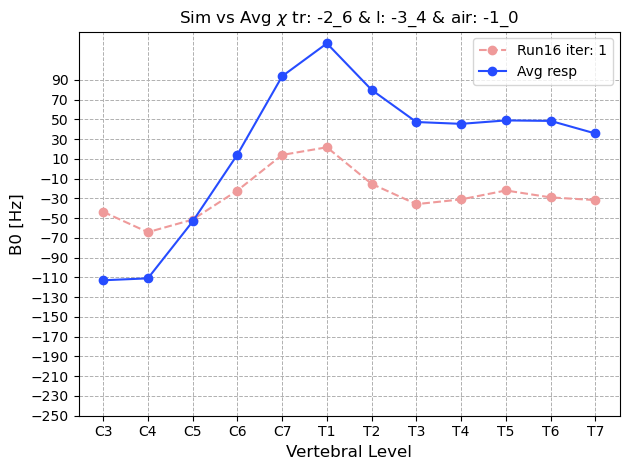

################
Iteration #2
Chi air : x[0] = -0.99999999
Vol_air Tr:  0.8
Vol_air_lungs: 0.7
Demod value for Simulation:  -389.79873859314586
Saving dmod FM...  dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv




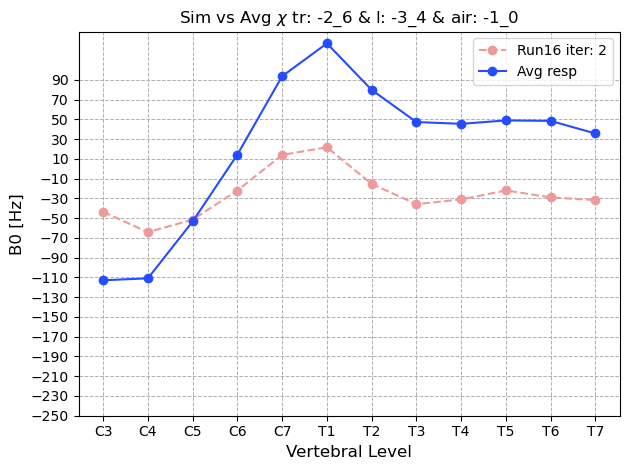

################
Iteration #3
Chi air : x[0] = -1.0
Vol_air Tr:  0.8000000100000001
Vol_air_lungs: 0.7
Demod value for Simulation:  -389.79873859475896
Saving dmod FM...  dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv




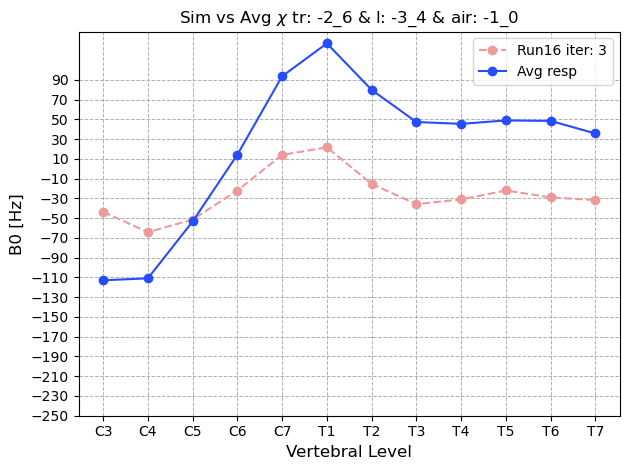

################
Iteration #4
Chi air : x[0] = -1.0
Vol_air Tr:  0.8
Vol_air_lungs: 0.70000001
Demod value for Simulation:  -389.7987385777847
Saving dmod FM...  dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-2_6_l_-3_4_air_-1_0_Hz.csv




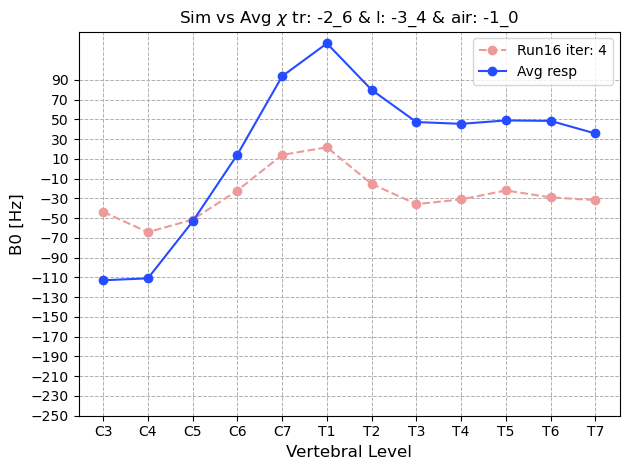

################
Iteration #5
Chi air : x[0] = 0.5
Vol_air Tr:  0.9
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.382551122862
Saving dmod FM...  dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv




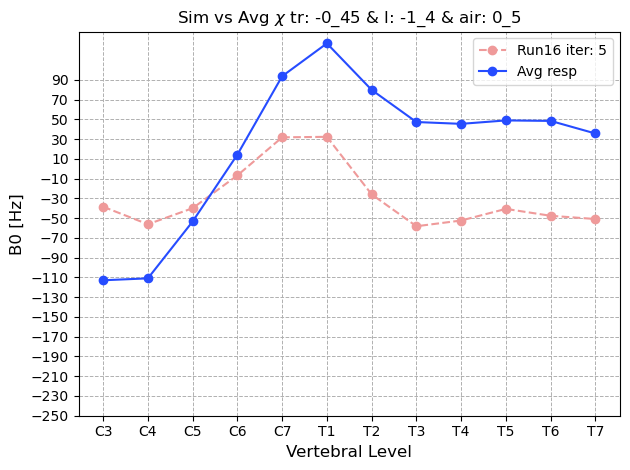

################
Iteration #6
Chi air : x[0] = 0.49999999
Vol_air Tr:  0.9
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.38255112452595
Saving dmod FM...  dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv




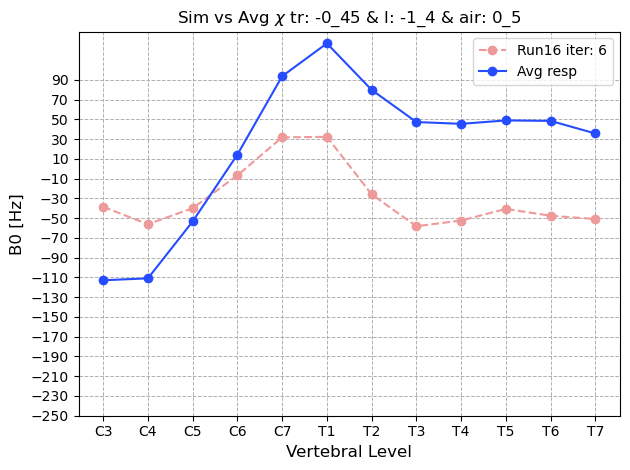

################
Iteration #7
Chi air : x[0] = 0.5
Vol_air Tr:  0.89999999
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.38255112267495
Saving dmod FM...  dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv




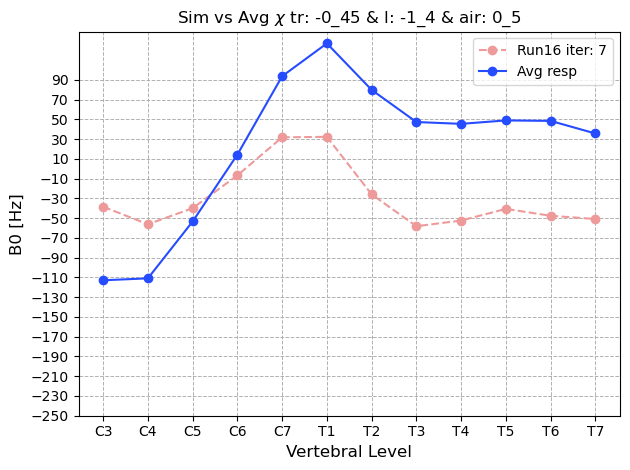

################
Iteration #8
Chi air : x[0] = 0.5
Vol_air Tr:  0.9
Vol_air_lungs: 0.79999999
Demod value for Simulation:  -389.38255114283197
Saving dmod FM...  dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_45_l_-1_4_air_0_5_Hz.csv




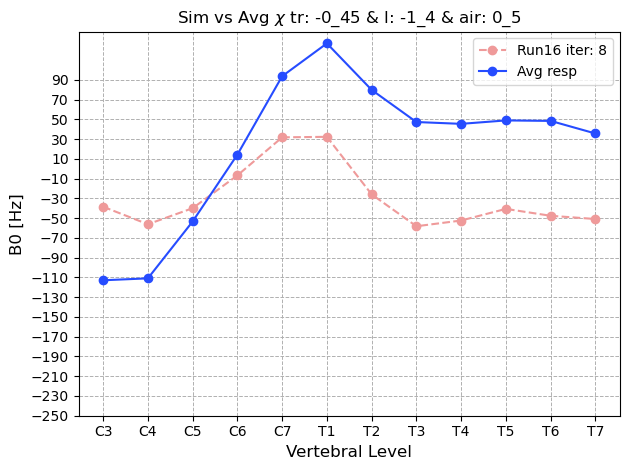

################
Iteration #9
Chi air : x[0] = 0.4461173520961917
Vol_air Tr:  0.8877589346307062
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3912894340519
Saving dmod FM...  dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv




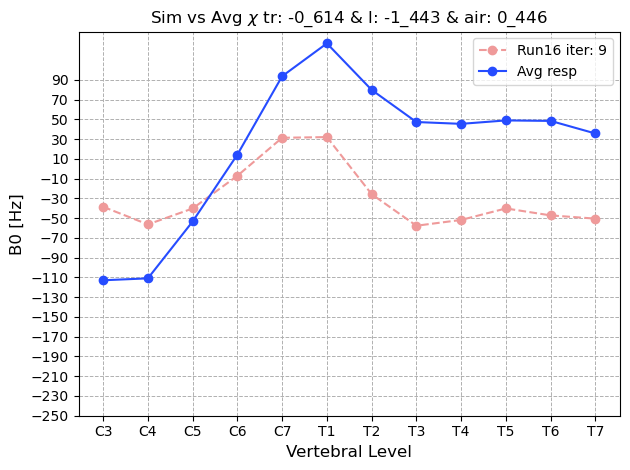

################
Iteration #10
Chi air : x[0] = 0.4461173620961917
Vol_air Tr:  0.8877589346307062
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3912894323876
Saving dmod FM...  dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv




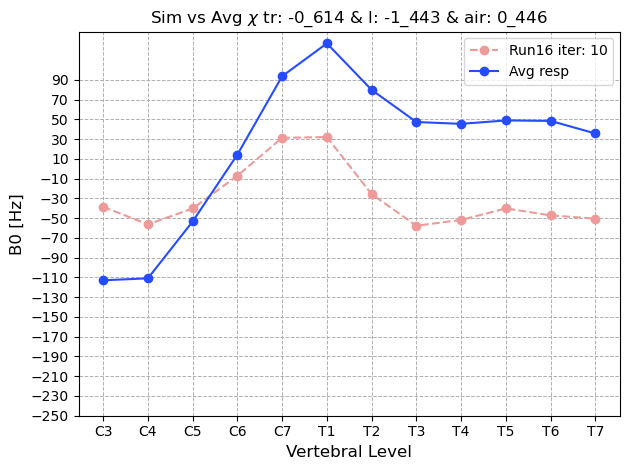

################
Iteration #11
Chi air : x[0] = 0.4461173520961917
Vol_air Tr:  0.8877589446307063
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3912894342378
Saving dmod FM...  dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv




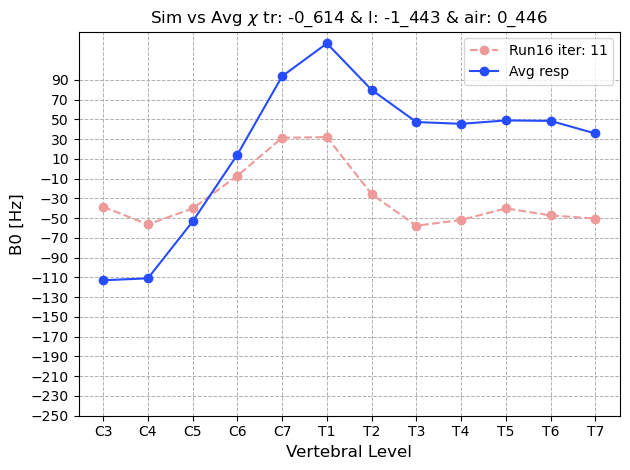

################
Iteration #12
Chi air : x[0] = 0.4461173520961917
Vol_air Tr:  0.8877589346307062
Vol_air_lungs: 0.79999999
Demod value for Simulation:  -389.39128945390854
Saving dmod FM...  dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-0_614_l_-1_443_air_0_446_Hz.csv




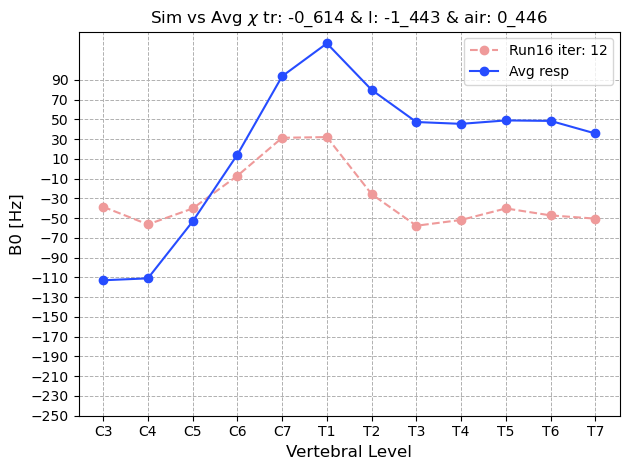

################
Iteration #13
Chi air : x[0] = 0.3400208416085175
Vol_air Tr:  0.8426608537503698
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.4081171002645
Saving dmod FM...  dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv




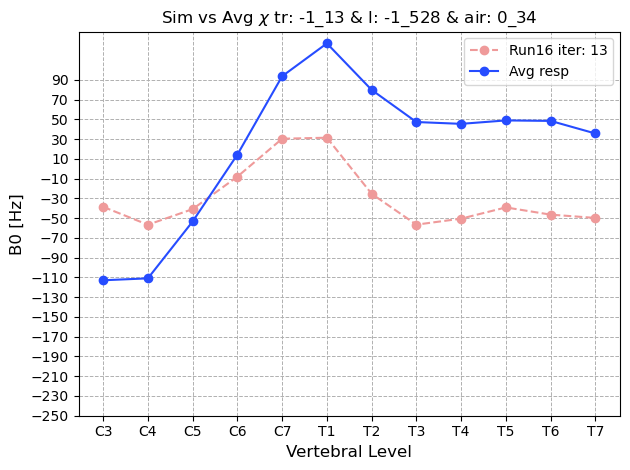

################
Iteration #14
Chi air : x[0] = 0.34002085160851747
Vol_air Tr:  0.8426608537503698
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.40811709859946
Saving dmod FM...  dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv




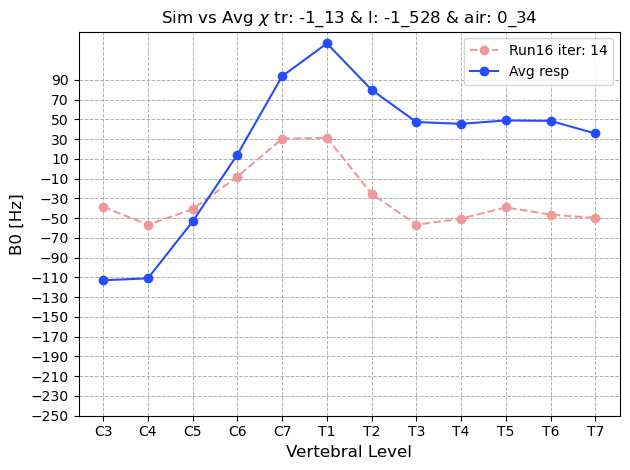

################
Iteration #15
Chi air : x[0] = 0.3400208416085175
Vol_air Tr:  0.8426608637503699
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.4081171004484
Saving dmod FM...  dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv




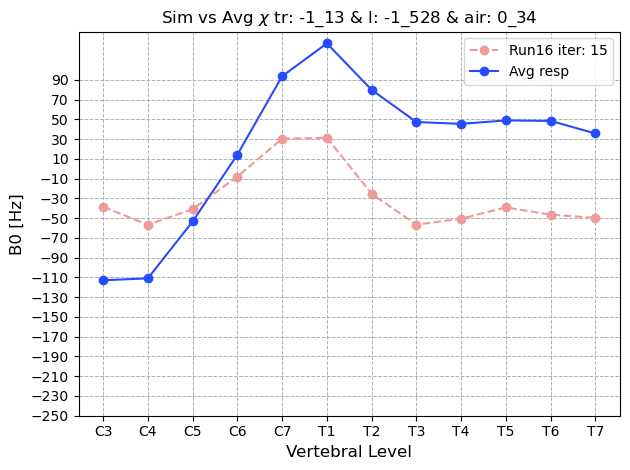

################
Iteration #16
Chi air : x[0] = 0.3400208416085175
Vol_air Tr:  0.8426608537503698
Vol_air_lungs: 0.79999999
Demod value for Simulation:  -389.4081171198981
Saving dmod FM...  dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_13_l_-1_528_air_0_34_Hz.csv




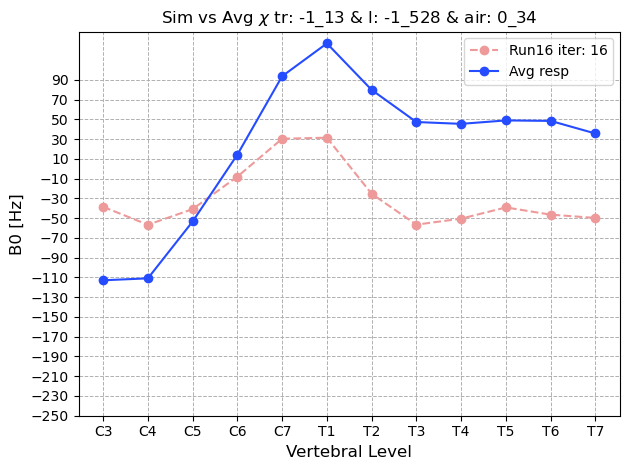

################
Iteration #17
Chi air : x[0] = 0.31861353556982847
Vol_air Tr:  0.8
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.4108992548487
Saving dmod FM...  dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv




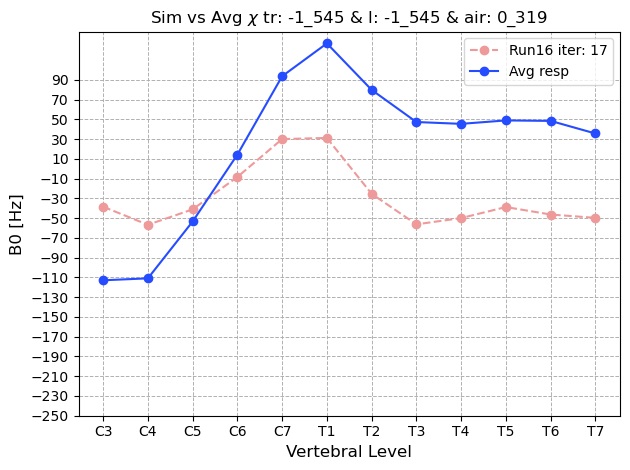

################
Iteration #18
Chi air : x[0] = 0.31861354556982846
Vol_air Tr:  0.8
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.4108992531827
Saving dmod FM...  dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv




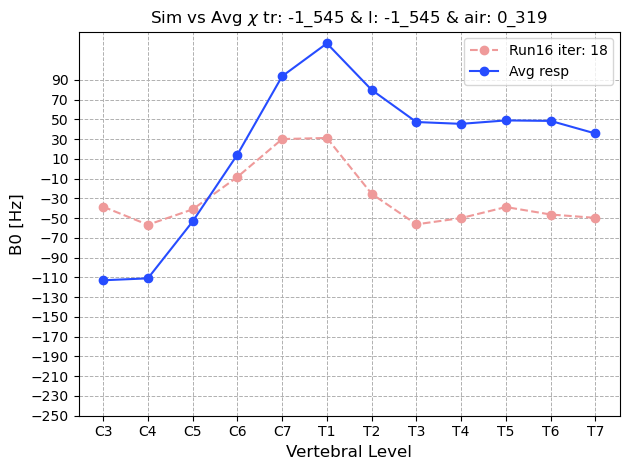

################
Iteration #19
Chi air : x[0] = 0.31861353556982847
Vol_air Tr:  0.8000000100000001
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.4108992550321
Saving dmod FM...  dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv




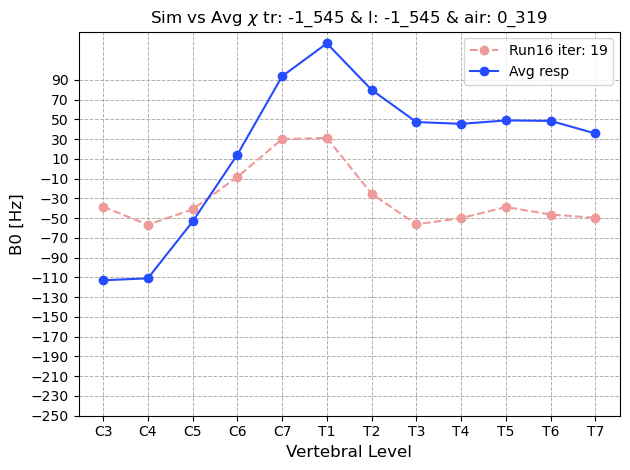

################
Iteration #20
Chi air : x[0] = 0.31861353556982847
Vol_air Tr:  0.8
Vol_air_lungs: 0.79999999
Demod value for Simulation:  -389.4108992744372
Saving dmod FM...  dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_545_l_-1_545_air_0_319_Hz.csv




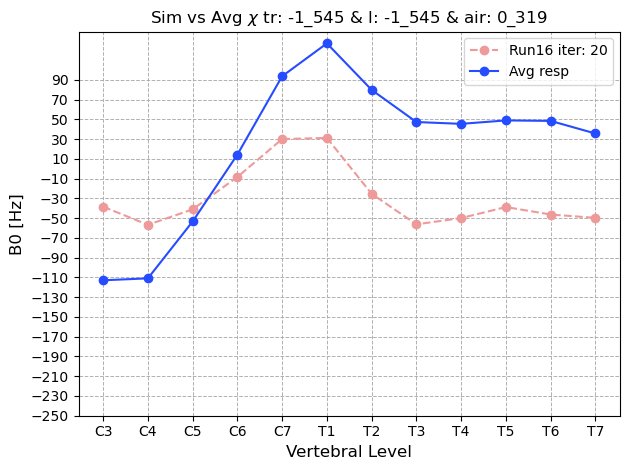

################
Iteration #21
Chi air : x[0] = 0.39084552168975156
Vol_air Tr:  0.8
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3988659066426
Saving dmod FM...  dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv




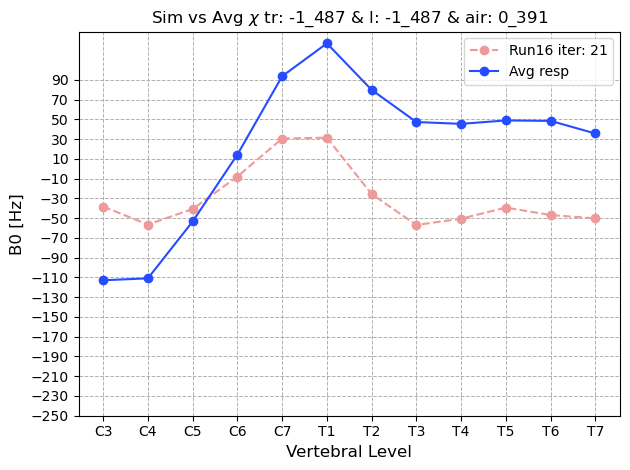

################
Iteration #22
Chi air : x[0] = 0.39084553168975156
Vol_air Tr:  0.8
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.39886590497673
Saving dmod FM...  dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv




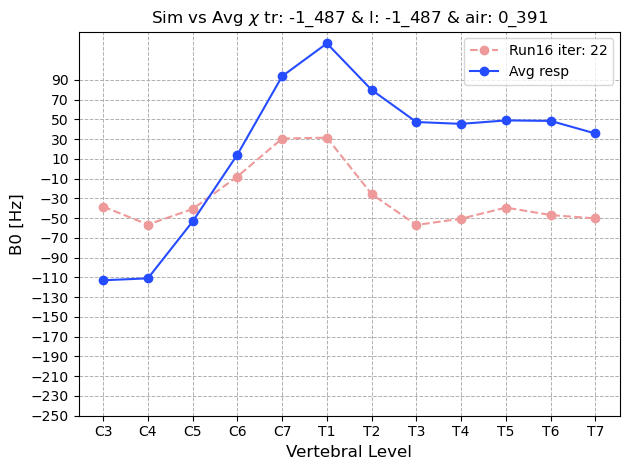

################
Iteration #23
Chi air : x[0] = 0.39084552168975156
Vol_air Tr:  0.8000000100000001
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3988659068274
Saving dmod FM...  dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv




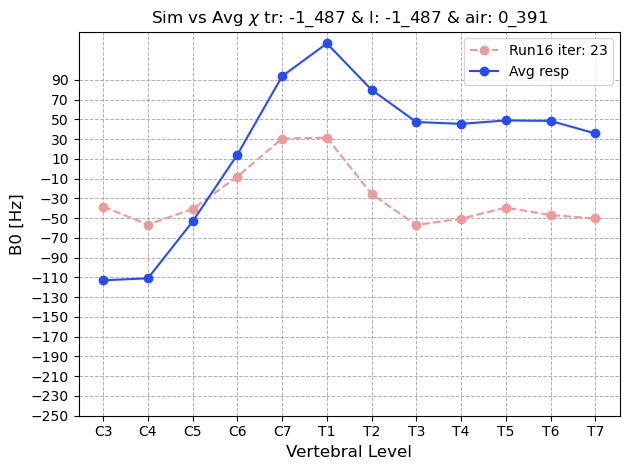

################
Iteration #24
Chi air : x[0] = 0.39084552168975156
Vol_air Tr:  0.8
Vol_air_lungs: 0.79999999
Demod value for Simulation:  -389.398865926383
Saving dmod FM...  dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_487_l_-1_487_air_0_391_Hz.csv




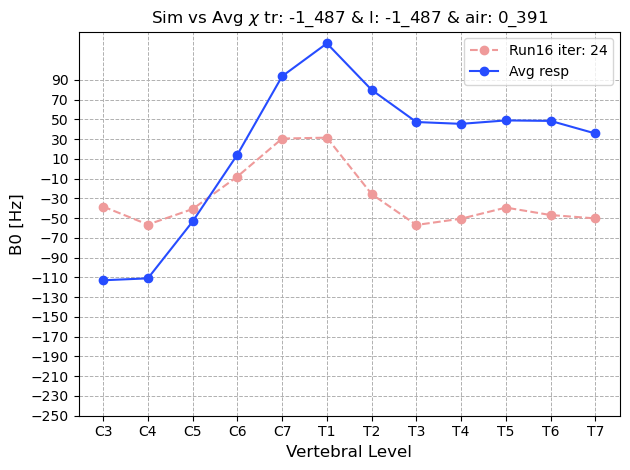

################
Iteration #25
Chi air : x[0] = 0.5
Vol_air Tr:  0.8
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.38068152716863
Saving dmod FM...  dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv




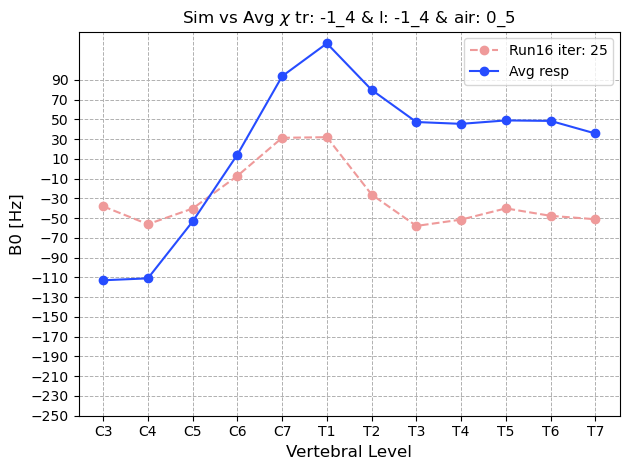

################
Iteration #26
Chi air : x[0] = 0.49999999
Vol_air Tr:  0.8
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3806815288346
Saving dmod FM...  dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv




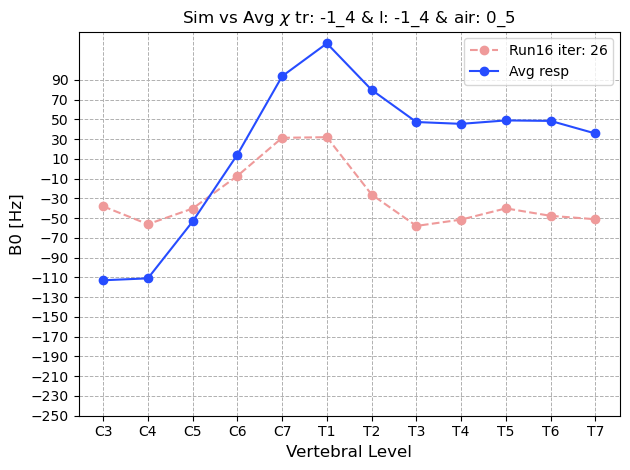

################
Iteration #27
Chi air : x[0] = 0.5
Vol_air Tr:  0.8000000100000001
Vol_air_lungs: 0.8
Demod value for Simulation:  -389.3806815273557
Saving dmod FM...  dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv




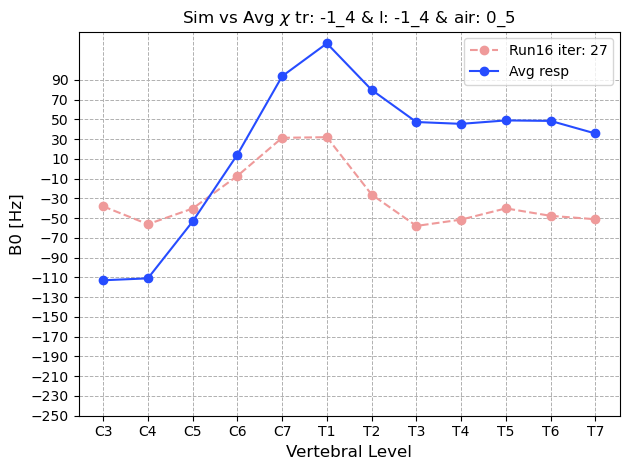

################
Iteration #28
Chi air : x[0] = 0.5
Vol_air Tr:  0.8
Vol_air_lungs: 0.79999999
Demod value for Simulation:  -389.3806815471385
Saving dmod FM...  dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.5)

sct_extract_metric -i E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_fms/run1\dmod_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:14 -vertfile E:/msc_data/ismrm_2025/dB0_033_dup1/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/dB0_033_dup1/fm/chi-opt/iteration_metrics/run1\metrics_sim_fm_tr_-1_4_l_-1_4_air_0_5_Hz.csv




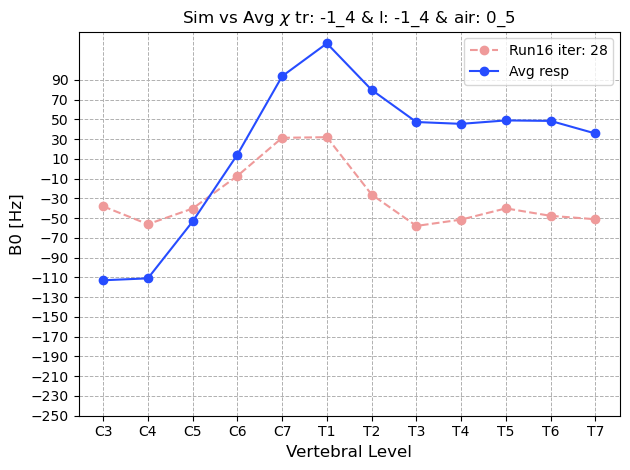

Optimization result:   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 297.3910737271507
        x: [ 5.000e-01  8.000e-01  8.000e-01]
      nit: 6
      jac: [-5.604e-02  1.340e+00 -2.006e+00]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
######## ############## ############### #############


<Figure size 640x480 with 0 Axes>

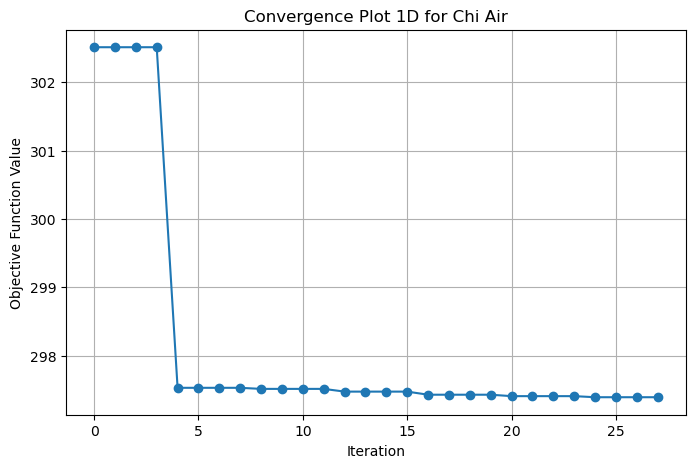

In [44]:
# Set initial values, boundaries and run optimization
initial_values = [-1, 0.8, 0.7] # Body should begin
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
bounds = [(-1, 0.5),(0.8,0.9),(0.6,0.8)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_dmod_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_dmod_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_dmod_fms)
    
    result = optimize.minimize(f_iair_vol_avg_resp_plot, initial_values, bounds = bounds, method = 'L-BFGS-B')

    # Output the result
    print("Optimization result:", result)
    print("######## ############## ############### #############")
    
    plt.figure()
    chi_values_range = np.linspace(-1, 0.5, 100)

    plt.figure(figsize=(8, 5))
    plt.plot(history, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Convergence Plot 1D for Chi Air")
    plt.grid()
    plt.show()

In [89]:
os.path.exists(path_to_iter_dmod_fms)

True

# <span style="color:chocolate"> *Plot and compare!* </span> 

In [42]:
# Load specific metrics by name, from output log
run2_iter20 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-5_16_l_-0_389_Hz.csv")
run2_iter20_values = run2_iter20["WA()"]
run2_iter20_values = run2_iter20_values[::-1]

In [54]:
run4_last_iter = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run4/metrics_sim_fm_tr_-5_0_l_-0_575_Hz.csv")
run4_last_iter_vals = run4_last_iter["WA()"]
run4_last_iter_vals = run4_last_iter_vals[::-1]

In [70]:
# One with x lung far from that range
run6 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run6/metrics_sim_fm_tr_-2_0_l_1_0_Hz.csv")
run6_values = run6["WA()"][::-1]

In [106]:
run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7/metrics_sim_fm_tr_-2_0_l_0_0_Hz.csv")
run7_values = run7["WA()"][::-1]
run7_values

12   -179.632875
11   -142.424619
10    -76.976387
9      -0.345025
8      93.837069
7      89.462894
6       7.859834
5     -26.918593
4      -4.591906
3      32.335572
2      53.256685
1      41.671918
0      39.592175
Name: WA(), dtype: float64

In [107]:
first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")
first_run7_vals = first_run7["WA()"][::-1]
first_run7_vals

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_49552\3367052066.py:1: SyntaxWarning: invalid escape sequence '\m'
  first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")


12   -219.740118
11   -189.120055
10   -135.339877
9     -74.304475
8      13.790056
7      51.663695
6      43.468552
5      41.938307
4      59.908588
3      84.494172
2     100.697910
1      91.271720
0      81.204982
Name: WA(), dtype: float64

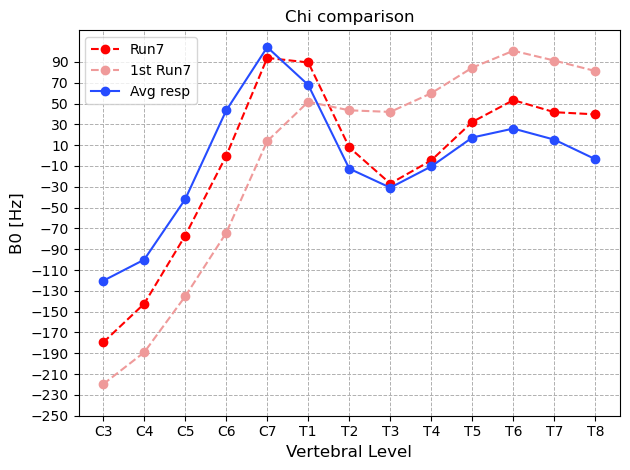

In [121]:
# We already have the cervical level and measured, 
# Copy the last (or any) fm metric name from SCT result

#final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics\metrics_sim_fm_tr_-14_0_l_-0_277_Hz.csv")
final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-9_0_l_-0_443_Hz.csv")

dmod_sim_vert_values = final_dmod["WA()"]
dmod_sim_vert_values = dmod_sim_vert_values[::-1]

vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 3 to 15


#plt.plot(vertebrae_levels, dmod_b0meas_vert_values, marker = 'x', linestyle = '-', label = "Measured Exp", color = "#ff4900") 
#plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = "Run1", color = "#33C3FF") 
#plt.plot(vertebrae_levels, run6_values, marker = 'o', linestyle = '--', label = "Run6", color = "#FBC02D") 
plt.plot(vertebrae_levels, run7_values, marker = 'o', linestyle = '--', label = "Run7", color = "red") 
plt.plot(vertebrae_levels, first_run7_vals, marker = 'o', linestyle = '--', label = "1st Run7", color = "#EF9A9A") 
#plt.plot(vertebrae_levels, run4_last_iter_vals, marker = 'o', linestyle = '--', label = "Run4", color = "#81C784") 
plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 

# Adding expiration and inspiration measured values
#plt.plot(vertebrae_levels, exp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Expiration B0 measured", color = "#ff4900")
#plt.plot(vertebrae_levels, insp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Inspiration B0 measured", color = "#ffad00")
#plt.plot(vertebrae_levels, avg_respiration, marker = 'o', linestyle = ':', label = "Avg respiratin B0 meas", color = "#264cff")
plt.title("Chi comparison")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()

yticks = range(-250, 101, 20) 
plt.yticks(yticks)


# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [2]:
dir ()

['In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__vsc_ipynb_file__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'open',
 'quit']